In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import MaxNLocator
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)
import copy

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
input_shape = (28, 28, 1)

In [3]:
def create_train_test_buckets(x_train, y_train, x_test, y_test):
    '''
    
    '''
    partitioned_train_arrays = {}
    numpy_partitioned_train_arrays = {}

    train_mix_fraction = 0.1
    test_mix_fraction = 0.1

    train_mix_length = int(len(x_train)*train_mix_fraction)
    test_mix_length = int(len(x_test)*test_mix_fraction)

    for item in zip(x_train,y_train):
        partitioned_train_arrays[item[1]]=([],[])

    for item in zip(x_train[:train_mix_length],y_train[:train_mix_length]):
        partitioned_train_arrays[item[1]][0].append(item[0])
        partitioned_train_arrays[item[1]][1].append(item[1])

    for item in zip(x_train[train_mix_length:],y_train[train_mix_length:]):
        random_bucket = int(np.random.randint(0,10,1))
        partitioned_train_arrays[random_bucket][0].append(item[0])
        partitioned_train_arrays[random_bucket][1].append(item[1])

    for item in partitioned_train_arrays:
        numpy_partitioned_train_arrays[item] = (np.array(partitioned_train_arrays[item][0]), np.array(partitioned_train_arrays[item][1]))

        
    partitioned_test_arrays = {}
    numpy_partitioned_test_arrays = {}


    for item in zip(x_test,y_test):
        partitioned_test_arrays[item[1]]=([],[])

    for item in zip(x_test[:test_mix_length],y_test[:test_mix_length]):
        partitioned_test_arrays[item[1]][0].append(item[0])
        partitioned_test_arrays[item[1]][1].append(item[1])

    for item in zip(x_test[test_mix_length:],y_test[test_mix_length:]):
        random_bucket = int(np.random.randint(0,10))
        partitioned_test_arrays[random_bucket][0].append(item[0])
        partitioned_test_arrays[random_bucket][1].append(item[1])


    for item in partitioned_test_arrays:
        partitioned_test_arrays[item] = (np.array(partitioned_test_arrays[item][0]), np.array(partitioned_test_arrays[item][1]))

    return(numpy_partitioned_train_arrays, partitioned_test_arrays)

In [4]:
partitioned_train_arrays, partitioned_test_arrays = create_train_test_buckets(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


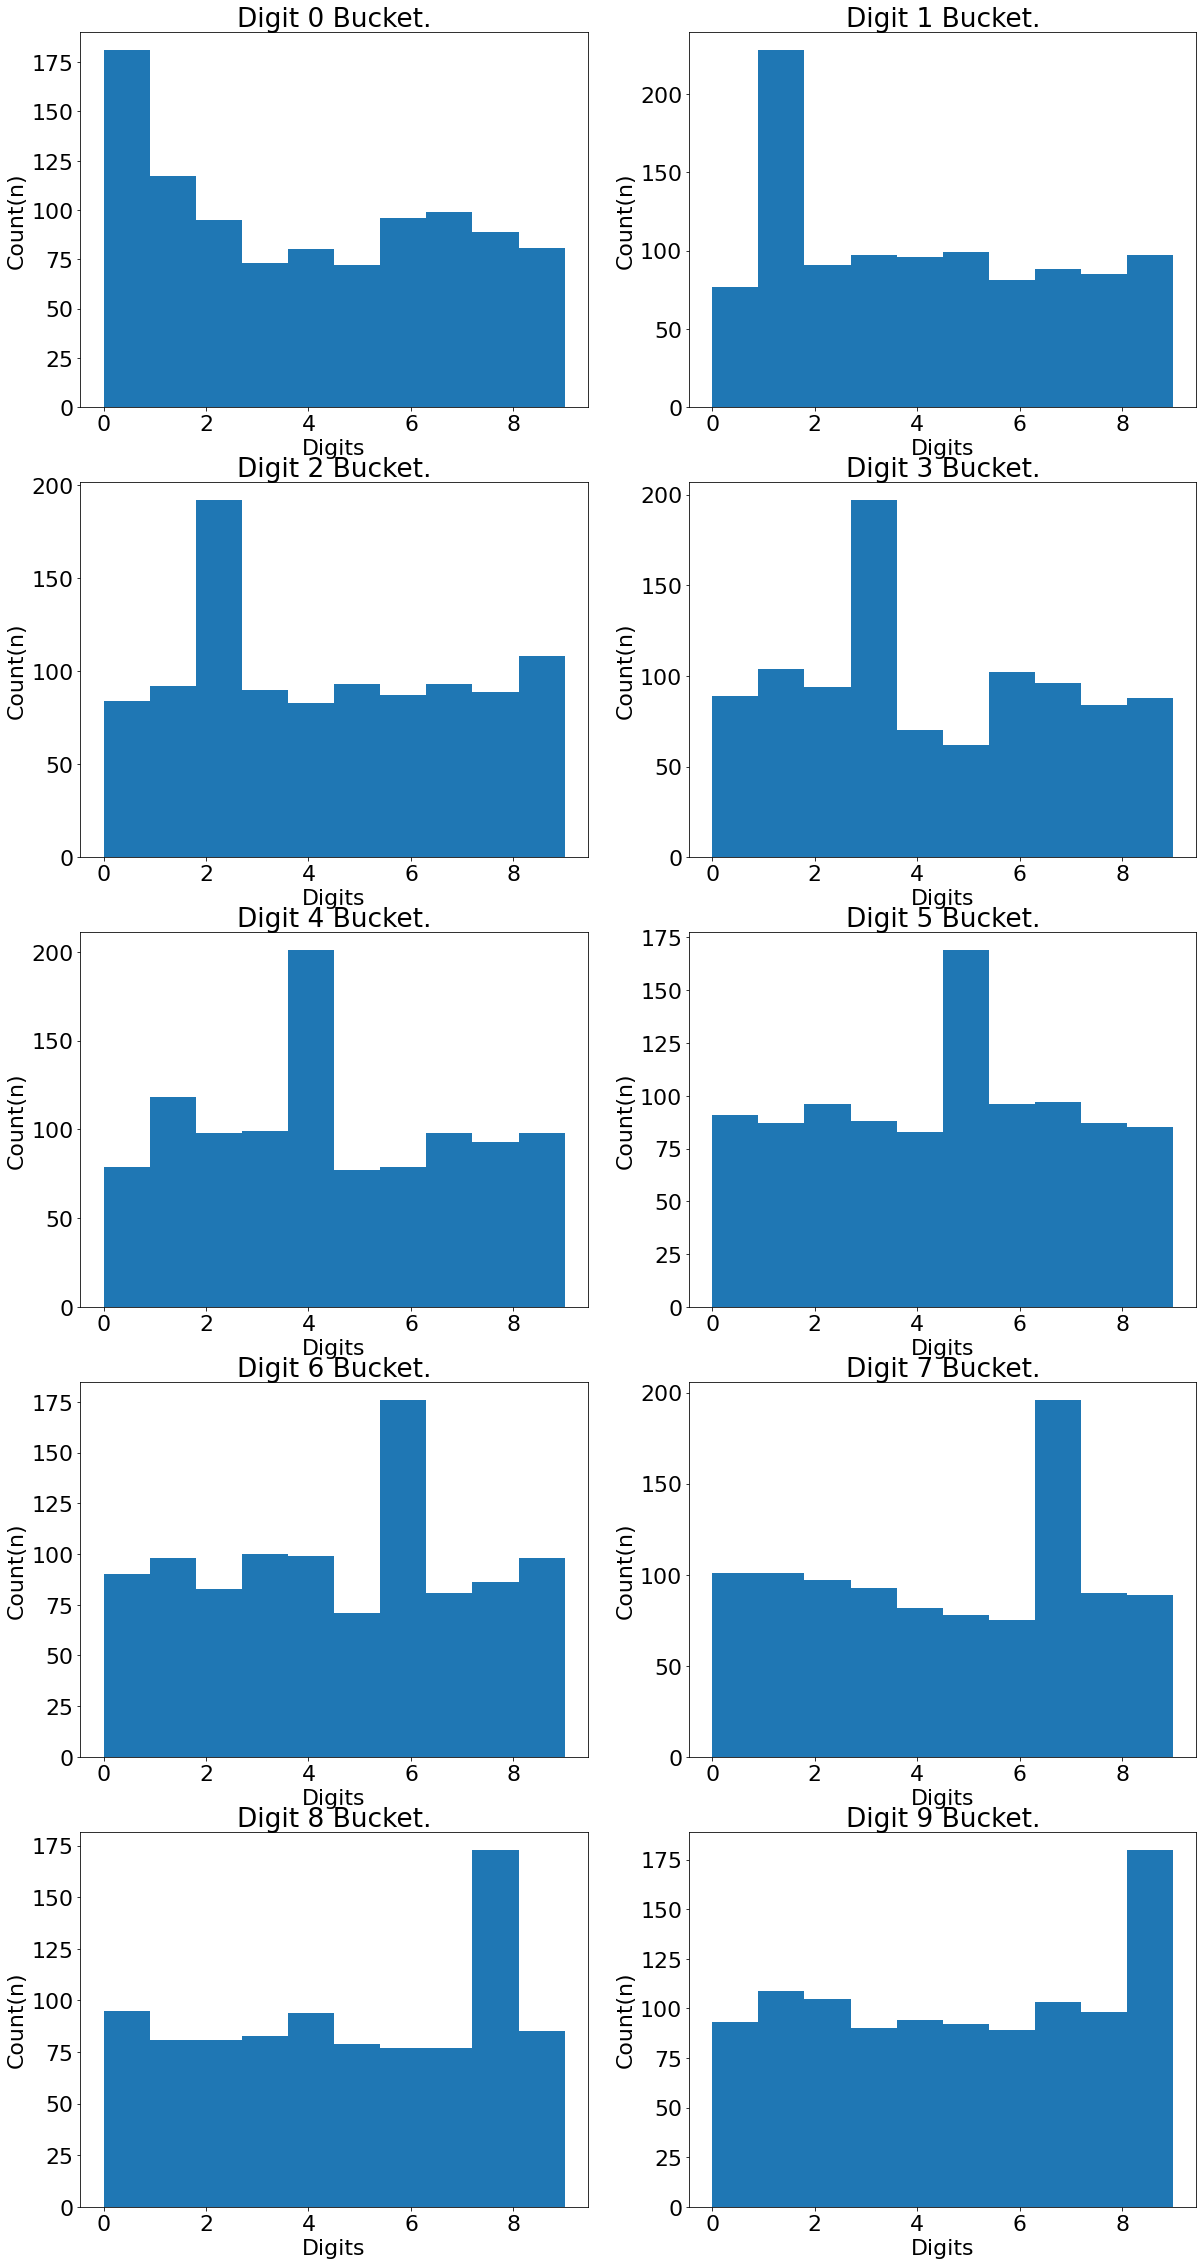

In [5]:
fig1, axs = plt.subplots(5,2, figsize=(20,40))
for row in range(5):
    for col in range(2):
        axs[row, col].hist(partitioned_test_arrays[row*2+col][1])
        axs[row, col].set_title('Digit {} Bucket.'.format(row*2+col))
        axs[row, col].set(xlabel='Digits', ylabel='Count(n)')

In [6]:
def create_keras_model():
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(28, kernel_size=(5,5),input_shape=input_shape),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Conv2D(14, kernel_size=(5,5)),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128,activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(84,activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10, activation=tf.nn.softmax)
    ])

'numpy_partitioned_train_arrays' is dictionary with 10 keys corresponding to 0,1, ..., 9 digits.

In [15]:
def local_train(model, model_index, partitioned_train_arrays, partitioned_test_arrays, x_test, y_test, train_sample_count=100):
    x_train_reshaped = partitioned_train_arrays[model_index][0].reshape(-1,28,28,1)
    y_train_reshaped = partitioned_train_arrays[model_index][1]

    random_rows = np.random.choice(x_train_reshaped.shape[0], train_sample_count, replace=False)

    x_train_partitioned = x_train_reshaped[random_rows,:]
    y_train_partitioned = y_train_reshaped[random_rows]
    model.fit(x=x_train_partitioned, y=y_train_partitioned, epochs=1)
    
    x_test_partitioned = partitioned_test_arrays[model_index][0].reshape(-1,28,28,1)
    y_test_partitioned = partitioned_test_arrays[model_index][1]
    
    train_accuracy = model.evaluate(x_train_partitioned, y_train_partitioned)
    local_test_acciracy = model.evaluate(x_test_partitioned.reshape(-1,28,28,1), y_test_partitioned)
    global_test_accuracy = model.evaluate(x_test.reshape(-1,28,28,1), y_test)
    
    print('Accuracies: Training={}, Local Test={}, Global Test={}'.format(train_accuracy[1], local_test_acciracy[1], global_test_accuracy[1]))
    return(model, train_accuracy, local_test_acciracy, global_test_accuracy)
    

In [8]:
def average_models_weights(models_collection):
    '''
    '''
    
    weights = [models_collection[model].get_weights() for model in models_collection]

    new_weights = copy.copy(np.array(weights).mean(axis=0, out=None))

    new_model = create_keras_model()
    new_model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    new_model.set_weights(new_weights)
    
    return(new_model)

## Regular Training (Non-Federated)

In [ ]:
model_global = create_keras_model()
model_global.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])
print('total model layers', np.shape(model_global.layers))

models_collection = {}
experiment_prefix = 'regular_'
for item in range(10):
    models_collection['model_{}'.format(item)] = 0
    tf.keras.models.save_model(model=model_global, filepath='{}model_{}'.format(experiment_prefix,item))
    
training_round = 25
training_round_accuracies_regular = []
train_sample_count=100
digits_to_train = 2

for iteration in range(training_round):
    print('Starting iteration: {}'.format(iteration))

    models_accuracies = []
    for model in range(digits_to_train):
        current_model = tf.keras.models.load_model('{}model_{}'.format(experiment_prefix,model))
        #models_collection[model].compile(optimizer='adam',
        #    loss='sparse_categorical_crossentropy',
        #    metrics=['accuracy'])
        results = local_train(model=current_model,
                        model_index=int(model),
                        partitioned_train_arrays=partitioned_train_arrays,
                        partitioned_test_arrays=partitioned_test_arrays,
                        x_test = x_test,
                        y_test = y_test,
                        train_sample_count=train_sample_count)
        #print(model,models_collection['model_0'].get_weights()[0][0][0][0][0])
        #print(model,models_collection['model_1'].get_weights()[0][0][0][0][0])
        #models_collection[model] = tf.keras.models.clone_model(results[0])
        tf.keras.models.save_model(results[0], filepath='{}model_{}'.format(experiment_prefix,model)j)
        model_accuracies = [results[1][1], results[2][1], results[3][1]]
        models_accuracies.append(model_accuracies)

    training_round_accuracies_regular.append(models_accuracies)

    
    print('Finieshed iteration: {}'.format(iteration))
    
    

total model layers (10,)
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: regular_model_0/assets
INFO:tensorflow:Assets written to: regular_model_1/assets
INFO:tensorflow:Assets written to: regular_model_2/assets
INFO:tensorflow:Assets written to: regular_model_3/assets
INFO:tensorflow:Assets written to: regular_model_4/assets
INFO:tensorflow:Assets written to: regular_model_5/assets
INFO:tensorflow:Assets written to: regular_model_6/assets
INFO:tensorflow:Assets written to: regular_model_7/assets
INFO:tensorflow:Assets written to: regular_model_8/assets
INFO:tensorflow:Assets written to: regular_model_9/assets
Starting iteration: 0
313/313 [==============================] - 2s 7ms/step - loss: 12.8248 - accuracy: 0.2380
Accuracies: Training=0.41999998688697815, Local Test=0.28484848141670227, Global Test=0.23800000548362732
INFO:tensorflow:Assets written to: regular_model_0/assets
313/313 [=============================

313/313 [==============================] - 2s 7ms/step - loss: 7.5509 - accuracy: 0.2776
Accuracies: Training=0.33000001311302185, Local Test=0.24680432677268982, Global Test=0.2775999903678894
INFO:tensorflow:Assets written to: regular_model_4/assets
313/313 [==============================] - 2s 8ms/step - loss: 11.3369 - accuracy: 0.2492
Accuracies: Training=0.3700000047683716, Local Test=0.25797101855278015, Global Test=0.2492000013589859
INFO:tensorflow:Assets written to: regular_model_5/assets
313/313 [==============================] - 3s 9ms/step - loss: 7.9917 - accuracy: 0.2978
Accuracies: Training=0.3700000047683716, Local Test=0.30390143394470215, Global Test=0.2978000044822693
INFO:tensorflow:Assets written to: regular_model_6/assets
313/313 [==============================] - 3s 11ms/step - loss: 11.6291 - accuracy: 0.2776
Accuracies: Training=0.3700000047683716, Local Test=0.2489919364452362, Global Test=0.2775999903678894
INFO:tensorflow:Assets written to: regular_model_7/

Finieshed iteration: 2
Starting iteration: 3
313/313 [==============================] - 2s 8ms/step - loss: 5.0677 - accuracy: 0.4549
Accuracies: Training=0.5400000214576721, Local Test=0.49494948983192444, Global Test=0.45489999651908875
INFO:tensorflow:Assets written to: regular_model_0/assets
313/313 [==============================] - 3s 9ms/step - loss: 6.0401 - accuracy: 0.4664
Accuracies: Training=0.5899999737739563, Local Test=0.5053243041038513, Global Test=0.46639999747276306
INFO:tensorflow:Assets written to: regular_model_1/assets
313/313 [==============================] - 3s 9ms/step - loss: 7.9898 - accuracy: 0.3384
Accuracies: Training=0.41999998688697815, Local Test=0.36298567056655884, Global Test=0.3384000062942505
INFO:tensorflow:Assets written to: regular_model_2/assets
313/313 [==============================] - 3s 10ms/step - loss: 7.5065 - accuracy: 0.3714
Accuracies: Training=0.5299999713897705, Local Test=0.3914342522621155, Global Test=0.37139999866485596
INFO:t

313/313 [==============================] - 3s 10ms/step - loss: 8.7167 - accuracy: 0.3264
Accuracies: Training=0.4099999964237213, Local Test=0.3726899325847626, Global Test=0.3264000117778778
INFO:tensorflow:Assets written to: regular_model_6/assets
313/313 [==============================] - 2s 7ms/step - loss: 7.2877 - accuracy: 0.3670
Accuracies: Training=0.5699999928474426, Local Test=0.39818549156188965, Global Test=0.367000013589859
INFO:tensorflow:Assets written to: regular_model_7/assets
313/313 [==============================] - 3s 8ms/step - loss: 5.2801 - accuracy: 0.4452
Accuracies: Training=0.49000000953674316, Local Test=0.4170905351638794, Global Test=0.44519999623298645
INFO:tensorflow:Assets written to: regular_model_8/assets
313/313 [==============================] - 2s 8ms/step - loss: 5.2879 - accuracy: 0.3978
Accuracies: Training=0.6299999952316284, Local Test=0.43661972880363464, Global Test=0.3977999985218048
INFO:tensorflow:Assets written to: regular_model_9/ass

313/313 [==============================] - 2s 8ms/step - loss: 5.5632 - accuracy: 0.3515
Accuracies: Training=0.36000001430511475, Local Test=0.37525561451911926, Global Test=0.351500004529953
INFO:tensorflow:Assets written to: regular_model_2/assets
313/313 [==============================] - 2s 8ms/step - loss: 5.5276 - accuracy: 0.4510
Accuracies: Training=0.5600000023841858, Local Test=0.49900397658348083, Global Test=0.45100000500679016
INFO:tensorflow:Assets written to: regular_model_3/assets
313/313 [==============================] - 2s 7ms/step - loss: 3.7366 - accuracy: 0.5527
Accuracies: Training=0.6600000262260437, Local Test=0.5516223907470703, Global Test=0.5526999831199646
INFO:tensorflow:Assets written to: regular_model_4/assets
313/313 [==============================] - 3s 8ms/step - loss: 3.2910 - accuracy: 0.5112
Accuracies: Training=0.5799999833106995, Local Test=0.5024154782295227, Global Test=0.5112000107765198
INFO:tensorflow:Assets written to: regular_model_5/asse

313/313 [==============================] - 2s 7ms/step - loss: 4.3737 - accuracy: 0.4752
Accuracies: Training=0.6600000262260437, Local Test=0.4883011281490326, Global Test=0.47519999742507935
INFO:tensorflow:Assets written to: regular_model_8/assets
313/313 [==============================] - 3s 9ms/step - loss: 4.9871 - accuracy: 0.4454
Accuracies: Training=0.5, Local Test=0.4959758520126343, Global Test=0.4453999996185303
INFO:tensorflow:Assets written to: regular_model_9/assets
Finieshed iteration: 7
Starting iteration: 8
313/313 [==============================] - 3s 9ms/step - loss: 3.6676 - accuracy: 0.5365
Accuracies: Training=0.6600000262260437, Local Test=0.5979797840118408, Global Test=0.5364999771118164
INFO:tensorflow:Assets written to: regular_model_0/assets
313/313 [==============================] - 3s 8ms/step - loss: 3.1221 - accuracy: 0.5576
Accuracies: Training=0.7300000190734863, Local Test=0.608906090259552, Global Test=0.5576000213623047
INFO:tensorflow:Assets writt

313/313 [==============================] - 2s 8ms/step - loss: 3.2631 - accuracy: 0.5884
Accuracies: Training=0.6399999856948853, Local Test=0.6155359148979187, Global Test=0.5884000062942505
INFO:tensorflow:Assets written to: regular_model_4/assets
313/313 [==============================] - 3s 9ms/step - loss: 2.8813 - accuracy: 0.5480
Accuracies: Training=0.6899999976158142, Local Test=0.5487922430038452, Global Test=0.5479999780654907
INFO:tensorflow:Assets written to: regular_model_5/assets
313/313 [==============================] - 3s 8ms/step - loss: 2.9857 - accuracy: 0.5399
Accuracies: Training=0.7200000286102295, Local Test=0.5544148087501526, Global Test=0.539900004863739
INFO:tensorflow:Assets written to: regular_model_6/assets
313/313 [==============================] - 4s 12ms/step - loss: 2.8770 - accuracy: 0.5530
Accuracies: Training=0.699999988079071, Local Test=0.5685483813285828, Global Test=0.5529999732971191
INFO:tensorflow:Assets written to: regular_model_7/assets
3

313/313 [==============================] - 2s 8ms/step - loss: 2.9588 - accuracy: 0.5867
Accuracies: Training=0.7300000190734863, Local Test=0.6272727251052856, Global Test=0.5867000222206116
INFO:tensorflow:Assets written to: regular_model_0/assets
313/313 [==============================] - 3s 8ms/step - loss: 3.5139 - accuracy: 0.5502
Accuracies: Training=0.7400000095367432, Local Test=0.593417227268219, Global Test=0.5501999855041504
INFO:tensorflow:Assets written to: regular_model_1/assets
313/313 [==============================] - 2s 7ms/step - loss: 2.9970 - accuracy: 0.5540
Accuracies: Training=0.7699999809265137, Local Test=0.6063394546508789, Global Test=0.5540000200271606
INFO:tensorflow:Assets written to: regular_model_2/assets
313/313 [==============================] - 2s 8ms/step - loss: 2.9088 - accuracy: 0.5785
Accuracies: Training=0.6700000166893005, Local Test=0.5966135263442993, Global Test=0.578499972820282
INFO:tensorflow:Assets written to: regular_model_3/assets
31

313/313 [==============================] - 2s 7ms/step - loss: 3.1247 - accuracy: 0.5491
Accuracies: Training=0.6600000262260437, Local Test=0.5698152184486389, Global Test=0.5490999817848206
INFO:tensorflow:Assets written to: regular_model_6/assets
313/313 [==============================] - 3s 8ms/step - loss: 2.7813 - accuracy: 0.5976
Accuracies: Training=0.7300000190734863, Local Test=0.6018145084381104, Global Test=0.597599983215332
INFO:tensorflow:Assets written to: regular_model_7/assets
313/313 [==============================] - 3s 10ms/step - loss: 2.1978 - accuracy: 0.6070
Accuracies: Training=0.7900000214576721, Local Test=0.6286876797676086, Global Test=0.6069999933242798
INFO:tensorflow:Assets written to: regular_model_8/assets
313/313 [==============================] - 3s 8ms/step - loss: 3.1283 - accuracy: 0.5645
Accuracies: Training=0.6399999856948853, Local Test=0.559356153011322, Global Test=0.5644999742507935
INFO:tensorflow:Assets written to: regular_model_9/assets
F

In [1]:
fig2, ax1 = plt.subplots(1,1, figsize=(20,10))
plt.plot(np.array(training_round_accuracies_regular).mean(axis=1)*100, linewidth=6)
plt.grid()
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_xlabel('Iterations (n)')
ax1.set_ylabel('Accuracy (%)')
ax1.legend(('Training (Local Data)', 'Testing (Local Test Data)', 'Testing (Global Test Data)'))



NameError: name 'plt' is not defined

## Federated Learning

In [ ]:
model_global = create_keras_model()
model_global.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])
print('total model layers', np.shape(model_global.layers))

models_collection = {}
experiment_prefix = 'federated_'
digits_to_train = 2
for item in range(digits_to_train):
    models_collection['model_{}'.format(item)] = 0
    tf.keras.models.save_model(model=model_global, filepath='{}model_{}'.format(experiment_prefix,item))
    


training_round = 25
training_round_accuracies_federated_learning = []
train_sample_count=10

for iteration in range(training_round):
    print('Starting iteration: {}'.format(iteration))

    models_accuracies = []
    for model in range(digits_to_train):
        #models_collection[model].compile(optimizer='adam',
        #    loss='sparse_categorical_crossentropy',
        #    metrics=['accuracy'])
        current_model = tf.keras.models.load_model('{}model_{}'.format(experiment_prefix,item))
        results = local_train(model=current_model,
                        model_index=int(model),#int(model.strip('model_')),
                        partitioned_train_arrays=partitioned_train_arrays,
                        partitioned_test_arrays=partitioned_test_arrays,
                        x_test = x_test,
                        y_test = y_test,
                        train_sample_count=train_sample_count)
        
        '''
        Exteremely important to use "tf.keras.models.clone_model(results[0])" in the next
        line. Even copy.copy(results[0]) would produce a referenced model with the same weights/
        ''' 
        #print(model,models_collection['model_0'].get_weights()[0][0][0][0][0])
        #print(model,models_collection['model_1'].get_weights()[0][0][0][0][0])
        #models_collection[model] = tf.keras.models.clone_model(results[0])
        #print('Model {} updated!'.format(model))
        tf.keras.models.save_model(results[0], filepath='{}model_{}'.format(experiment_prefix,model))
        model_accuracies = [results[1][1], results[2][1], results[3][1]]
        models_accuracies.append(model_accuracies)

    training_round_accuracies_federated_learning.append(models_accuracies)
    print('Averaging Models')
    

    models_collection = {}
    for item in range(digits_to_train):
        models_collection['model_{}'.format(item)] = tf.keras.models.load_model('{}model_{}'.format(experiment_prefix,item))

    model_global = copy.copy(average_models_weights(models_collection))
    print('total model layers', np.shape(model_global.layers))

    models_collection = {}
    for item in range(digits_to_train):
        tf.keras.models.save_model(model_global, filepath='{}model_{}'.format(experiment_prefix,item))
        #models_collection['model_{}'.format(item)] = copy.copy(model_global)
    #print('Model Memory IDs: {}, {}'.format(id(models_collection['model_0']),id(models_collection['model_1'])))
    
    print('Finieshed iteration: {}'.format(iteration))
    
    

total model layers (10,)
INFO:tensorflow:Assets written to: federated_model_0/assets
INFO:tensorflow:Assets written to: federated_model_1/assets
Starting iteration: 0
313/313 [==============================] - 2s 8ms/step - loss: 41.1892 - accuracy: 0.1204
Accuracies: Training=0.5, Local Test=0.20040692389011383, Global Test=0.12039999663829803
INFO:tensorflow:Assets written to: federated_model_0/assets
313/313 [==============================] - 3s 9ms/step - loss: 36.9716 - accuracy: 0.1005A: 2s
Accuracies: Training=0.20000000298023224, Local Test=0.08758421242237091, Global Test=0.10050000250339508
INFO:tensorflow:Assets written to: federated_model_1/assets
Averaging Models
total model layers (10,)
INFO:tensorflow:Assets written to: federated_model_0/assets
INFO:tensorflow:Assets written to: federated_model_1/assets
Finieshed iteration: 0
Starting iteration: 1
313/313 [==============================] - 3s 10ms/step - loss: 27.1227 - accuracy: 0.0983
Accuracies: Training=0.40000000596

313/313 [==============================] - 3s 8ms/step - loss: 12.1598 - accuracy: 0.2289
Accuracies: Training=0.5, Local Test=0.25409045815467834, Global Test=0.2289000004529953
INFO:tensorflow:Assets written to: federated_model_1/assets
Averaging Models
total model layers (10,)
INFO:tensorflow:Assets written to: federated_model_0/assets
INFO:tensorflow:Assets written to: federated_model_1/assets
Finieshed iteration: 6
Starting iteration: 7
313/313 [==============================] - 3s 8ms/step - loss: 13.3853 - accuracy: 0.2012
Accuracies: Training=0.4000000059604645, Local Test=0.2563580870628357, Global Test=0.2011999934911728
INFO:tensorflow:Assets written to: federated_model_0/assets
313/313 [==============================] - 3s 10ms/step - loss: 11.2339 - accuracy: 0.1892
Accuracies: Training=0.20000000298023224, Local Test=0.18190567195415497, Global Test=0.1891999989748001
INFO:tensorflow:Assets written to: federated_model_1/assets
Averaging Models
total model layers (10,)
INF

313/313 [==============================] - 3s 10ms/step - loss: 7.9974 - accuracy: 0.3071
Accuracies: Training=0.4000000059604645, Local Test=0.36012208461761475, Global Test=0.30709999799728394
INFO:tensorflow:Assets written to: federated_model_0/assets
313/313 [==============================] - 2s 7ms/step - loss: 7.8339 - accuracy: 0.2980
Accuracies: Training=0.5, Local Test=0.2993262708187103, Global Test=0.2980000078678131
INFO:tensorflow:Assets written to: federated_model_1/assets
Averaging Models
total model layers (10,)
INFO:tensorflow:Assets written to: federated_model_0/assets
INFO:tensorflow:Assets written to: federated_model_1/assets
Finieshed iteration: 13
Starting iteration: 14
313/313 [==============================] - 2s 8ms/step - loss: 10.1687 - accuracy: 0.2723
Accuracies: Training=0.30000001192092896, Local Test=0.31230926513671875, Global Test=0.27230000495910645
INFO:tensorflow:Assets written to: federated_model_0/assets
313/313 [==============================] - 

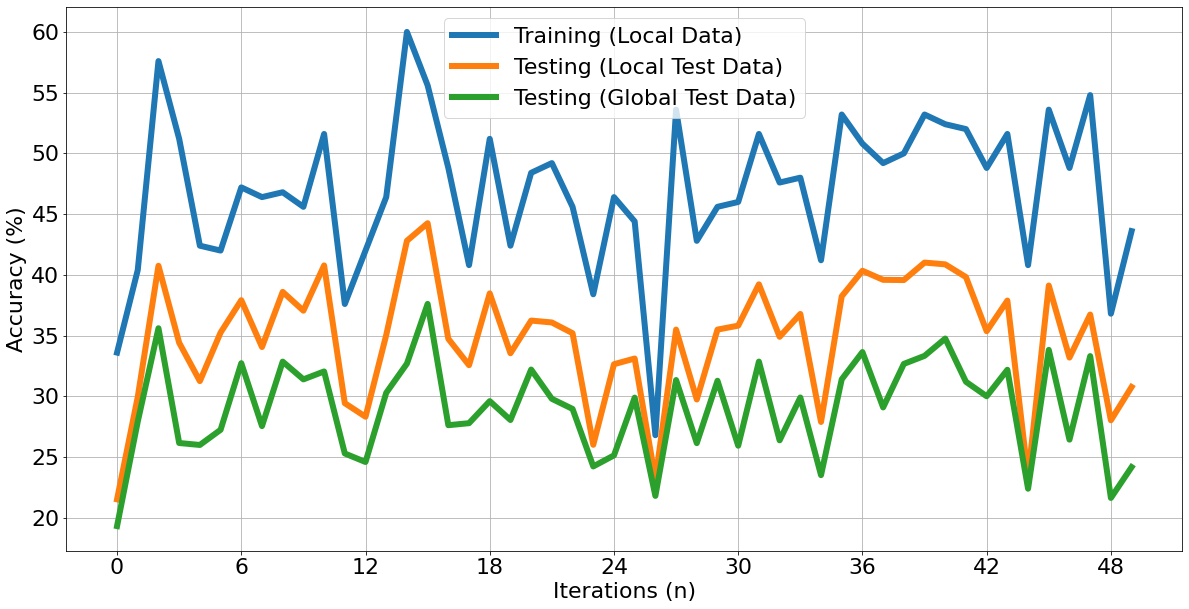

In [12]:
fig2, ax1 = plt.subplots(1,1, figsize=(20,10))
plt.plot(np.array(training_round_accuracies_federated_learning).mean(axis=1)*100, linewidth=6)
plt.grid()
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_xlabel('Iterations (n)')
ax1.set_ylabel('Accuracy (%)')
ax1.legend(('Training (Local Data)', 'Testing (Local Test Data)', 'Testing (Global Test Data)'))



In [13]:
len(training_round_accuracies_federated_learning)

50

## Federated Learning with Fine-Tuning

In [14]:
model_global = create_keras_model()
model_global.compile(optimizer='adam',
loss='sparse_categorical_crossentropy',
metrics=['accuracy'])
print('total model layers', np.shape(model_global.layers))

models_collection = {}
for item in range(10):
    models_collection['model_{}'.format(item)] = tf.keras.models.clone_model(model_global)
    


training_round = 50
training_round_accuracies_finetuned = []
train_sample_count= 25
for iteration in range(training_round):
    print('Starting iteration: {}'.format(iteration))

    models_accuracies = []
    for model in models_collection:
        models_collection[model].compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
        results = local_train(model=models_collection[model],
                        model_index=int(model.strip('model_')),
                        partitioned_train_arrays=partitioned_train_arrays,
                        partitioned_test_arrays=partitioned_test_arrays,
                        x_test = x_test,
                        y_test = y_test,
                        train_sample_count=train_sample_count)
        '''
        Exteremely important to use "tf.keras.models.clone_model(results[0])" in the next
        line. Even copy.copy(results[0]) would produce a referenced model with the same weights/
        ''' 
        models_collection[model] = tf.keras.models.clone_model(results[0])
        
        print(model,models_collection['model_0'].get_weights()[0][0][0][0][0])
        print(model,models_collection['model_1'].get_weights()[0][0][0][0][0])
        model_accuracies = [results[1][1], results[2][1], results[3][1]]
        models_accuracies.append(model_accuracies)

    training_round_accuracies_finetuned.append(models_accuracies)
    print('Averaging Models')
    
    if(iteration<10):
        model_global = average_models_weights(models_collection)
        print('total model layers', np.shape(model_global.layers))

        models_collection = {}
        for item in range(10):
            models_collection['model_{}'.format(item)] = model_global
    else:
        pass
    
    print('Finieshed iteration: {}'.format(iteration))
    
    

total model layers (10,)
Starting iteration: 0
313/313 [==============================] - 2s 8ms/step - loss: 33.7584 - accuracy: 0.1128
Accuracies: Training=0.11999999731779099, Local Test=0.12275132536888123, Global Test=0.1128000020980835
model_0 -0.03981837
model_0 0.015556887
313/313 [==============================] - 2s 7ms/step - loss: 28.0029 - accuracy: 0.1508
Accuracies: Training=0.2800000011920929, Local Test=0.13699907064437866, Global Test=0.15080000460147858
model_1 -0.03981837
model_1 -0.05382605
313/313 [==============================] - 2s 6ms/step - loss: 32.4193 - accuracy: 0.0678
Accuracies: Training=0.1599999964237213, Local Test=0.08879919350147247, Global Test=0.06780000030994415
model_2 -0.03981837
model_2 -0.05382605
313/313 [==============================] - 2s 7ms/step - loss: 24.5443 - accuracy: 0.1135
Accuracies: Training=0.3199999928474426, Local Test=0.24144868552684784, Global Test=0.11349999904632568
model_3 -0.03981837
model_3 -0.05382605
313/313 [====

313/313 [==============================] - 2s 7ms/step - loss: 2.2543 - accuracy: 0.1050
Accuracies: Training=0.3199999928474426, Local Test=0.31483349204063416, Global Test=0.10499999672174454
model_2 -0.0780969
model_2 -0.08810528
313/313 [==============================] - 2s 7ms/step - loss: 2.2025 - accuracy: 0.3046
Accuracies: Training=0.47999998927116394, Local Test=0.25150904059410095, Global Test=0.3046000003814697
model_3 -0.0780969
model_3 -0.08810528
313/313 [==============================] - 2s 7ms/step - loss: 2.1693 - accuracy: 0.1386
Accuracies: Training=0.36000001430511475, Local Test=0.3143143057823181, Global Test=0.13860000669956207
model_4 -0.0780969
model_4 -0.08810528
313/313 [==============================] - 2s 7ms/step - loss: 2.1275 - accuracy: 0.3513
Accuracies: Training=0.5600000023841858, Local Test=0.4104166626930237, Global Test=0.3513000011444092
model_5 -0.0780969
model_5 -0.08810528
313/313 [==============================] - 2s 6ms/step - loss: 2.0876 

313/313 [==============================] - 2s 7ms/step - loss: 2.1211 - accuracy: 0.4025
Accuracies: Training=0.4399999976158142, Local Test=0.3125, Global Test=0.4025000035762787
model_5 -0.05382774
model_5 0.09061906
313/313 [==============================] - 2s 6ms/step - loss: 2.0767 - accuracy: 0.3432
Accuracies: Training=0.6000000238418579, Local Test=0.4316546618938446, Global Test=0.3431999981403351
model_6 -0.05382774
model_6 0.09061906
313/313 [==============================] - 3s 8ms/step - loss: 2.0093 - accuracy: 0.4736
Accuracies: Training=0.47999998927116394, Local Test=0.45764362812042236, Global Test=0.47360000014305115
model_7 -0.05382774
model_7 0.09061906
313/313 [==============================] - 2s 7ms/step - loss: 1.9681 - accuracy: 0.3636
Accuracies: Training=0.5600000023841858, Local Test=0.39026716351509094, Global Test=0.3635999858379364
model_8 -0.05382774
model_8 0.09061906
313/313 [==============================] - 2s 7ms/step - loss: 1.9091 - accuracy: 0.

model_1 -0.02252733
model_1 -0.022300608
313/313 [==============================] - 2s 7ms/step - loss: 2.2520 - accuracy: 0.1521
Accuracies: Training=0.2800000011920929, Local Test=0.10998991131782532, Global Test=0.15209999680519104
model_2 -0.02252733
model_2 -0.022300608
313/313 [==============================] - 2s 7ms/step - loss: 2.2290 - accuracy: 0.2829
Accuracies: Training=0.5600000023841858, Local Test=0.43963783979415894, Global Test=0.28290000557899475
model_3 -0.02252733
model_3 -0.022300608
313/313 [==============================] - 2s 7ms/step - loss: 2.1791 - accuracy: 0.3887
Accuracies: Training=0.6000000238418579, Local Test=0.5155155062675476, Global Test=0.388700008392334
model_4 -0.02252733
model_4 -0.022300608
313/313 [==============================] - 2s 7ms/step - loss: 2.1779 - accuracy: 0.2068
Accuracies: Training=0.5199999809265137, Local Test=0.3385416567325592, Global Test=0.20679999887943268
model_5 -0.02252733
model_5 -0.022300608
313/313 [==============

KeyboardInterrupt: 

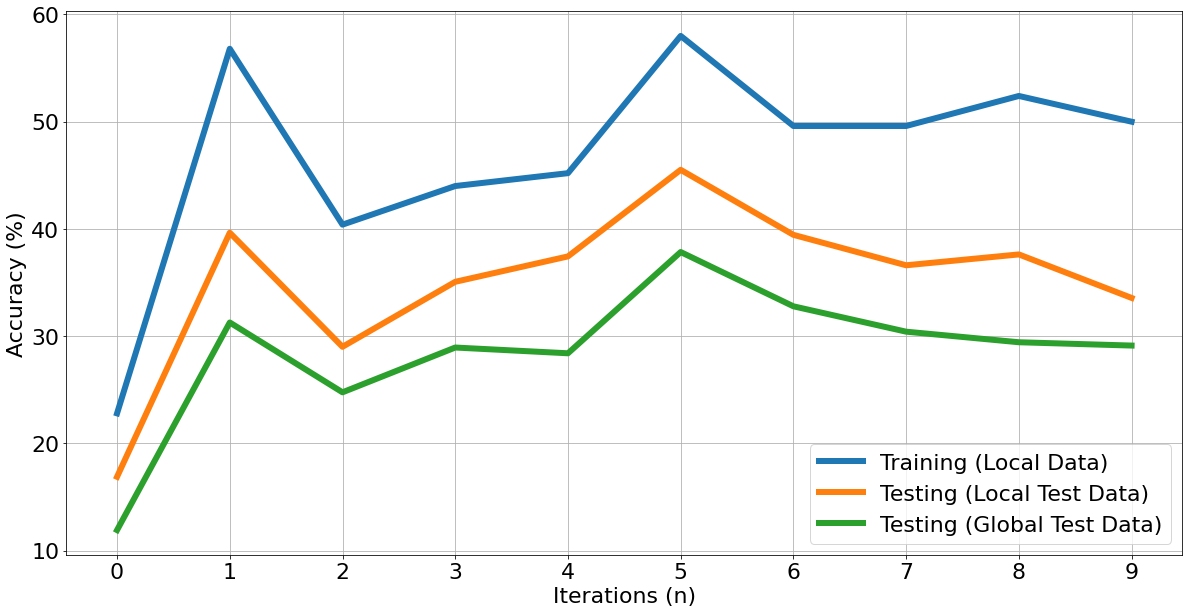

In [15]:
fig2, ax1 = plt.subplots(1,1, figsize=(20,10))
plt.plot(np.array(training_round_accuracies_finetuned).mean(axis=1)*100, linewidth=6)
plt.grid()
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_xlabel('Iterations (n)')
ax1.set_ylabel('Accuracy (%)')
ax1.legend(('Training (Local Data)', 'Testing (Local Test Data)', 'Testing (Global Test Data)'))

